# This Jupyter notebook describes the steps necessary to recreate the data for the Texas Attainment Map.

The code below describes in detail the process of converting the American Community Surevy data made available through [IPUMS-NHGIS](https://www.nhgis.org) to dots on a map. This project requires the following files which can be downloaded from NHGIS:
  * 2010 census block polygons for Texas
  * 2010 census table P1, Total Population, for census blocks
  * 2012-2016 5-year summary statistics for table B15001, educational attainment by age for each census tract. The census tract field (GISJOIN) will be used to merge the data to the census tract polygons.
  * 2016 census tract polygons (we downloaded the entire US census tract file, you will only need Texas)


### You will need access to:
  * ArcGIS (peferably with the advanced license - however, there are workarounds if you only have the basic license)
  * SAS 9.4 (there are many alternatives to SAS)


In [1]:
#These modules only load when launching in the arcgispro-3 environment
import arcpy
import os
import arcpy.management as mg
import re
import pandas as pd
arcpy.env.overwriteOutput = True
arcpy.env.randomGenerator = "5 MERSENNE_TWISTER" # set seed for random dots 
arcpy.env.qualifiedFieldNames = False

In [2]:
# Create a File Geodatabase to store the NoPopBlocks 
arcpy.CreateFileGDB_management("data", "Attainment.gdb")

<Result 'data\\Attainment.gdb'>

# Identify the places where there shouldn't be any dots

Census tracts include bodies of water, airports, and parks - places where people don't usually live.

Here is a census tract near downtown in Austin, Texas.
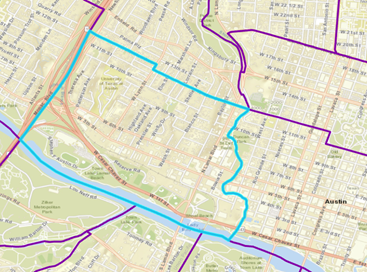

In order to avoid placing a dot representing 25 people with a bachelor's degree in the middle of Lady Bird Lake, or on a highway, or in a park, we will need adjust the census tract polygons. We do this using the much smaller census blocks from the 2010 census. 

Download and unzip the files from NHGIS. We'll begin by identifying all of the census blocks form the 2010 census with a population of zero. (Note: these census blocks with zero population highways and waterways that can divide entire census tracts.)



In [3]:
#######
#Create NoPopBlocks from data downloaded from NHGIS
#######

#The CensusBlock CSV file for Texas where H7v001=0 [i.e. population=0]

#Convert zipped CensusBlock csv file to dBase and limit to just Texas blocks where population=0.
CensusBlocks = pd.read_csv("data/OriginalDownloadfromNHGIS/nhgis0005_csv/nhgis0005_ds172_2010_block.csv",  usecols=[0,39])

NoPopBlocks=CensusBlocks.loc[CensusBlocks['H7V001'] == 0 ]

#set max rows to display when viewing dataframes
pd.options.display.max_rows = 10
print(NoPopBlocks)

#Save NoPopBlocks as a CSV
NoPopBlocks.to_csv('data/NoPopBlocks.csv', index=False)


                   GISJOIN  H7V001
3       G48000109501001003       0
4       G48000109501001004       0
7       G48000109501001007       0
8       G48000109501001008       0
11      G48000109501001011       0
...                    ...     ...
914197  G48050709503024041       0
914198  G48050709503024042       0
914201  G48050709503024045       0
914202  G48050709503024046       0
914203  G48050709503024047       0

[459573 rows x 2 columns]


In [4]:
#Get the NoPopBlocks table into the geodatabase
arcpy.TableToTable_conversion("data/NoPopBlocks.csv", "data/Attainment.gdb", "NoPopBlocksTable")

#Put TX census block polygons in GDB.
arcpy.FeatureClassToGeodatabase_conversion("data/OriginalDownloadfromNHGIS/nhgis0005_shapefile_tl2010_480_block_2010/TX_block_2010.shp", "data/Attainment.gdb")

#Index GISJOIN fields for improved performamce
arcpy.AddIndex_management ("data/Attainment.gdb/NoPopBlocksTable", "GISJOIN", "index1")

#Index GISJOIN fields for improved performamce
arcpy.AddIndex_management ("data/Attainment.gdb/TX_block_2010", "GISJOIN", "index2")

<Result 'data/Attainment.gdb/TX_block_2010'>

# Now we'll select all of the census blocks with zero population and save those polygons to the geodatabase.

In [5]:
#Get just the Census blocks with zero population

# Set local variables    
layerName = "TX_BlocksLayer"
joinTable = "data/Attainment.gdb/NoPopBlocksTable"
joinField = "GISJOIN"
outFeature = "data/Attainment.gdb/NoPopBlocks"
expression = "NoPopBlocksTable.H7V001 = 0"
    
#Load TX 2010 Census Blocks as Feature Layer
arcpy.MakeFeatureLayer_management("data/Attainment.gdb/TX_block_2010", "TX_BlocksLayer")
    
# Join the feature layer to a table. Use KEEP_COMMON to eleiminate need for arcpy.SelectLayerByAttribute_management()
arcpy.AddJoin_management(layerName, joinField, joinTable, joinField)
    
arcpy.SelectLayerByAttribute_management(layerName,"NEW_SELECTION", expression)
    
# Copy the layer to a new permanent feature class
arcpy.CopyFeatures_management(layerName, outFeature)


<Result 'data\\Attainment.gdb\\NoPopBlocks'>

# Now we can see all the 2010 census blocks with zero population (shown below in grey). 
Here we see the areas in grey where the population from the 2010 census was equal to 0. These areas include the lake, the highway, the park, and a lot of commercial areas of downtown Austin. 

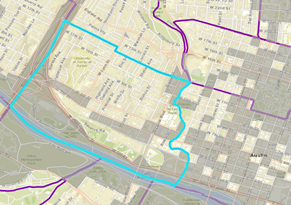


# Now we'll poke holes in the census tracts using the census block with zero population

Thanks to Prof. Walker at TCU for posting [his python code](https://github.com/walkerke/education_map) on how to do this.

### The blue outline shows a complete census tract, but here we modify it to remove the areas with zero population.

### The remaining area shown in green is the modified census tract.

Note: You will need the *advanced* ArcGIS license to use the erase tool. However, you can use the union tool to join the data for both layers and get the same result. Western Washington University has a helpful how-to [here](http://www.wwu.edu/huxley/spatial/tut/erase.htm).

What will be left of our census tracts is whown below in green.

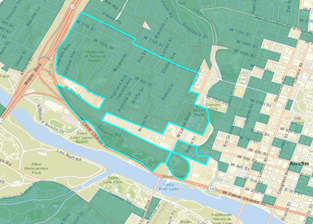

In [6]:
#Load Texas Census Tracts

#Make temporary CensusTract Layer
arcpy.MakeFeatureLayer_management("data/OriginalDownloadfromNHGIS/nhgis0006_shapefile_tl2016_us_tract_2016/us_tract_2016.shp", "CensusTractLayer")

#Select just the TX Census Tracts and save in GDB
arcpy.SelectLayerByAttribute_management("CensusTractLayer", "NEW_SELECTION", " STATEFP = '48' ")
arcpy.CopyFeatures_management("CensusTractLayer", "data/Attainment.gdb/TexasTracts")

#Erase the NoPopBlocks from the Texas Census Tracts
in_features =  "data/Attainment.gdb/TexasTracts"
erase_features = "data/Attainment.gdb/NoPopBlocks"
out_feature_class = "data/Attainment.gdb/BustedTracts"

arcpy.Erase_analysis(in_features, erase_features, out_feature_class)

<Result 'data\\Attainment.gdb\\BustedTracts'>

# This leaves some thin slices of census tracts.

That can complicate things when it comes to randomly placing the dots within the census tracts.

So we need to remove the slivers. We'll do so by eliminating isolated chuncks of census tracts < 5,000 sq. meters. This will leave us with our [dasymetric](https://www.e-education.psu.edu/geog486/node/1866) census tracts.

Note: Below, the Arcpy Add Geometry Attribute tool is providing a syntax warning but no apparent problem on execution.

In [7]:
#This will allow us to grab each piece of busted up Census Tract individually
arcpy.MultipartToSinglepart_management("data/Attainment.gdb/BustedTracts", "data/Attainment.gdb/SinglePartTracts")

# Check for slivers and remove them - let's set a threshold of 5000 sq meters
singlepart_layer = arcpy.MakeFeatureLayer_management("data/Attainment.gdb/SinglePartTracts")
arcpy.AddGeometryAttributes_management(singlepart_layer, Geometry_Properties = "AREA", Area_Unit = "SQUARE_METERS")
    #yes there is a syntax warning - as far as I can tell, it is just part of the arcpy script for that tool

# Now, specify the where clause and dissolve
area_clause = '"POLY_AREA" >= 5000'
arcpy.SelectLayerByAttribute_management(singlepart_layer, "NEW_SELECTION", area_clause)
out_dissolve = "data/DissolvedSinglepartTracts.shp"

arcpy.Dissolve_management(singlepart_layer, out_dissolve, dissolve_field = "GISJOIN")

<Result 'data\\DissolvedSinglepartTracts.shp'>

## Prepare the NHGIS attainment data by census tract  before continuing to the next step. 

I used SAS to generate the number of dots per level of attainment at each scale (1 dot =10 people, 25 people, 50 people, 100 people, and 150 people) for each census tract (GISJOIN field).

The output file is: *data\NHGIS0001_PreparedForMerge.csv*

### I used the following SAS code for preparing the NHGIS attainment data:

```sas

PROC IMPORT OUT= WORK.NHGIS0001
            DATAFILE= "data\OriginalDownloadfromNHGIS\nhgis0005_csv\nhgis0005_ds226_20165_2016_tract.csv"            
	 DBMS=CSV REPLACE;
     GETNAMES=YES;
     DATAROW=2; 
RUN;

/* Keep the GISJOIN field and make the following new variables:   
			High School or less, Some college no degree, Associates,   
			Bachelor's, Graduate or Professional Degree */
data AttainmentRaw;
set NHGIS0001;
where STATEA='48';
	Assoc = AGIEE016 + AGIEE057;
	Bacc =  AGIEE017 + AGIEE058;
	GradPro =  AGIEE018 + AGIEE059;
	SomeHE = AGIEE015 + AGIEE056;
	HSorLess = AGIEE012 + AGIEE013 + AGIEE014 + AGIEE053 + AGIEE054 + AGIEE055;
	TotalPop =  AGIEE001;
run;


data work.AttainmentbyCensusTract (keep=GISJOIN Assoc10 Assoc25 Assoc50 Assoc100 Assoc150 
		Bacc10 Bacc25 Bacc50 Bacc100 Bacc150 GradPro10 GradPro25 GradPro50 GradPro100 GradPro150 
		HSunder10 HSunder25 HSunder50 HSunder100 HSunder150 SomeHE10 SomeHE25 SomeHE50 SomeHE100 SomeHE150);
	set AttainmentRaw;

	Assoc10=Round(Assoc/10);
	Assoc25=Round(Assoc/25);
	Assoc50=Round(Assoc/50);
	Assoc100=Round(Assoc/100);
	Assoc150=Round(Assoc/150);

	Bacc10=Round(Bacc/10);
	Bacc25=Round(Bacc/25);
	Bacc50=Round(Bacc/50);
	Bacc100=Round(Bacc/100);
	Bacc150=Round(Bacc/150);

	GradPro10=Round(GradPro/10);
	GradPro25=Round(GradPro/25);
	GradPro50=Round(GradPro/50);
	GradPro100=Round(GradPro/100);
	GradPro150=Round(GradPro/150);

	SomeHE10=Round(SomeHE/10);
	SomeHE25=Round(SomeHE/25);
	SomeHE50=Round(SomeHE/50);
	SomeHE100=Round(SomeHE/100);
	SomeHE150=Round(SomeHE/150);

	HSunder10=Round(HSorLess/10);
	HSunder25=Round(HSorLess/25);
	HSunder50=Round(HSorLess/50);
	HSunder100=Round(HSorLess/100);
	HSunder150=Round(HSorLess/150);

run;



proc export data=work.AttainmentbyCensusTract
            outfile="data\DotCounts_PreparedForMerge.csv" 
            dbms=csv replace;
run;

```


#### The next step joins the output from SAS (number of dots per level of attainment at 5 different zoom layers for each census tract in Texas) to the census tract polygons.


In [8]:
#Merge the Dissolved_back_to_Tracks polygons with the .xls file exported from sas with the number of dots per tract

#Get .xls into GDB
arcpy.TableToTable_conversion("data/DotCounts_PreparedForMerge.csv", "data/Attainment.gdb", "AttainmentData_SASoutput")

#Index GISJOIN field for improved performamce
#arcpy.AddIndex_management ("data/Attainment.gdb/JoinedAttainmentData_DasymetricTracts", "GISJOIN", "GISIndex")

# Join the feature layer to a SAS output table
inFeatures = "data/DissolvedSinglepartTracts.shp"
layerName = "JoinedAttainmentData_DasymetricLayer"
joinTable = "data/Attainment.gdb/AttainmentData_SASoutput"
joinField = "GISJOIN"
outFeature = "data/Attainment.gdb/JoinedAttainmentData_DasymetricTracts"

# Create a feature layer 
arcpy.MakeFeatureLayer_management (inFeatures,  layerName)
    
# Join the feature layer to a table
arcpy.AddJoin_management(layerName, joinField, joinTable, joinField)

# Copy the layer to a new permanent feature class
arcpy.CopyFeatures_management(layerName, outFeature)

# Delete the temporary dissolved tracks shapefile
arcpy.Delete_management("data/DissolvedSinglepartTracts.shp")

<Result 'true'>

# And now we can make the dots!

The uses the arcpy.CreateRandomPoints tool which is also available only with the advanced license. There are [similar tools](http://ianbroad.com/arcgis-toolbox-generate-random-points-arcpy/) out there that may also get the job done.

Once we make random points within our modified census tracts **_we will no longer need any polygons or census shape data!_** 

From here on out, our data consists of X,Y coordinates associated with 
  * Level of educational attainment 
  * Approximate number of individuals represented by each point (i.e.: scale).

In [9]:
def MakePointLayers(scale):
    levels=["Assoc", "Bacc", "GradPro", "HSunder", "SomeHE"]
    for level in levels:

        outGDB = "data/Attainment.gdb"
        out_name= level + str(scale)
        constraining_feature_class = "data/Attainment.gdb/JoinedAttainmentData_DasymetricTracts"
        Field_with_Number_of_Random_Points = level + str(scale)
        Minimum_Distance_Between_Points= str(scale)
        
        
        arcpy.CreateRandomPoints_management(outGDB, out_name, constraining_feature_class, "", Field_with_Number_of_Random_Points, Minimum_Distance_Between_Points)    

scales=[10, 25, 50, 100, 150]
for scale in scales:
    MakePointLayers(scale)

# Here we'll add fields for scale and attainment level and then make a single shapefile for each level.

We made five scales. They are: 

    1 dot = 10 people, 25 people, 50 people, 100 people, and 150 people


In [10]:
#make a folder if it doesn't exist
if not os.path.exists("data/Shapefiles"):
    os.makedirs("data/Shapefiles")


def arcmap_to_geojson(scale):
        levels=["Assoc", "Bacc", "GradPro", "HSunder", "SomeHE"]
        for level in levels:
            layername = level + str(scale)
            layer = level + str(scale)
            arcpy.management.MakeFeatureLayer("data/Attainment.gdb/" + layername, layer)
            arcpy.management.AddField(layer, "scale", "SHORT")
            arcpy.management.CalculateField(layer, "scale", scale)
            arcpy.management.AddField(layer, "level", "TEXT")
            arcpy.management.CalculateField(layer, "level", "'"+level+"'")
        
def combine_levels_by_scale(scale):
    levels=["Assoc"+str(scale), "Bacc"+str(scale), "GradPro"+str(scale), "HSunder"+str(scale), "SomeHE"+str(scale)]
    
    # Use Merge tool to move features into single dataset, set spatial reference to WGS84
    CombinedFeature = "data/Attainment.gdb/TempAttainment" + str(scale)
    OutFeature = "data/Attainment.gdb/Attainment" + str(scale)
    
    arcpy.Merge_management(levels, CombinedFeature)
    arcpy.management.Project(CombinedFeature, OutFeature, arcpy.SpatialReference(4326))
    arcpy.FeatureClassToShapefile_conversion (OutFeature, "data/Shapefiles")
                
scales=[10, 25, 50, 100, 150]
for scale in scales:
    arcmap_to_geojson(scale)
    combine_levels_by_scale(scale)


# Now we can see the dots on a map!

The image below shows all of the dots in blue for scale=25. You can control the color using the 'Level' field later to contrast different degree types. Remember, the placement of the dots within the dasymetric census tract in random so a repeat of this process won't have dots in exactely the same place. But the number of dots per census tract would remain the same.

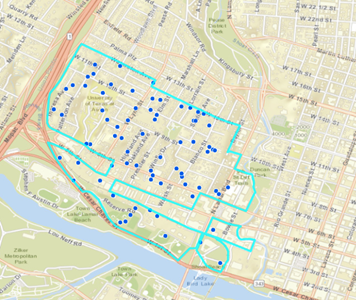


# From here you can upload the shapefiles to a service like Mapbox Studio 

This does not require linux, or bash on the newer versions of Windows 10, but mapbox may limit you to their pre-defined zoom levels.

# Or, define your own zoom levels by making .MBtiles using open source tools.

We made our own .MBtiles and then uploaded them to Mapbox to be served. 

### Frst, use the [ogr2ogr tool from the open source GDAL/OGR library](http://www.gdal.org/) to convert the shapefiles to GeoJSON.

Installed GDAL. Make a new, empty folder data/geojson. Using the command line, cd into the /data folder and run the tool with the following commands to convert each of the Shapefiles to geojson: 
```
ogr2ogr -f GeoJSON geojson/Attainment10.json Shapefiles/Attainment10.shp -progress
ogr2ogr -f GeoJSON geojson/Attainment25.json Shapefiles/Attainment25.shp -progress
ogr2ogr -f GeoJSON geojson/Attainment50.json Shapefiles/Attainment50.shp -progress
ogr2ogr -f GeoJSON geojson/Attainment100.json Shapefiles/Attainment100.shp -progress
ogr2ogr -f GeoJSON geojson/Attainment150.json Shapefiles/Attainment150.shp -progress
```

This outputs .json files of point data. 

### The [tippecanoe tool](https://github.com/mapbox/tippecanoe) takes .json data to make .MBtiles. Read the full documentation on GitHub for best results. We used tippecanoe with the following options for the different zoom levels: 

Install tippecanoe and run the following from the /data folder:

```
tippecanoe --output=Attainment150.mbtiles geojson/Attainment150.json -r1 --drop-fraction-as-needed --no-feature-limit --no-tile-size-limit --maximum-zoom=7 --minimum-zoom=5 --exclude=CID
tippecanoe --output=Attainment100.mbtiles geojson/Attainment100.json -r1 --drop-fraction-as-needed --no-feature-limit --no-tile-size-limit --maximum-zoom=9 --minimum-zoom=7 --exclude=CID
tippecanoe --output=Attainment50.mbtiles geojson/Attainment50.json -r1 --drop-fraction-as-needed --no-feature-limit --no-tile-size-limit --maximum-zoom=11 --minimum-zoom=9 --exclude=CID
tippecanoe --output=Attainment25.mbtiles geojson/Attainment25.json -r1 --drop-fraction-as-needed --no-feature-limit --no-tile-size-limit --maximum-zoom=13 --minimum-zoom=11 --exclude=CID
tippecanoe --output=Attainment10.mbtiles geojson/Attainment10.json -r1 --drop-fraction-as-needed --no-feature-limit --no-tile-size-limit --maximum-zoom=16.2 --minimum-zoom=13 --exclude=CID
```

### Finally, make things easier by combining the .MBtiles into a single source with tile-join.

tile-join comes with tippecanoe. Combine the .MBtiles with the following:
```
tile-join -o Attainment2012_2016.mbtiles Attainment150.mbtiles Attainment100.mbtiles Attainment50.mbtiles Attainment25.mbtiles Attainment10.mbtiles
```

You can serve your own MBtiles. We upload ours to Mapbox Studio.

For questions about this code, contact John Dinning at [john.dinning@THECB.state.tx.us](mailto:john.dinning@THECB.state.tx.us)
